# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import boto3
import sagemaker
import os
import io, requests, warnings
from sagemaker.amazon.amazon_estimator import get_image_uri
import json

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
from sagemaker.image_uris import retrieve

In [1]:
# Write the code here and add cells as you need
!pip install --upgrade sagemaker

In [58]:
# Write the final comments here and turn the cell type into markdown

In [32]:
# functions to generate charts
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(test_labels, target_predicted):
    # Generate the confusion matrix using sklearn
    cm = confusion_matrix(test_labels, target_predicted)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['No Delay', 'Delay'],
                yticklabels=['No Delay', 'Delay'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc(test_labels, target_probs):
    # Compute the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(test_labels, target_probs)

    # Compute the area under the ROC curve (AUC)
    auc_value = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(10,7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def generate_confusion_report(test_labels, target_predicted):
    # Generate the confusion matrix
    cm = confusion_matrix(test_labels, target_predicted)

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(cm)

    # Generate and print the classification report
    cr = classification_report(test_labels, target_predicted)
    print("\nClassification Report:")
    print(cr)

def get_general_results(test_labels, target_predicted):
    # Compute and print Accuracy
    accuracy = accuracy_score(test_labels, target_predicted)
    print(f"\nAccuracy: {accuracy}")

    # Compute and print Precision
    precision = precision_score(test_labels, target_predicted)
    print(f"Precision: {precision}")

    # Compute and print Recall/Sensitivity
    recall = recall_score(test_labels, target_predicted)
    print(f"Recall/Sensitivity: {recall}")

    # Compute and print F1 Score
    f1 = f1_score(test_labels, target_predicted)
    print(f"F1 Score: {f1}")

In [5]:
# reading the combined_csv_v1.csv data
csv_v1_data = pd.read_csv('combined_csv_v1.csv')
csv_v1_data.dropna(inplace=True)
csv_v1_data = csv_v1_data.astype('float64')

In [6]:
csv_v1_data.columns

Index(['target', 'Distance', 'DepHourofDay', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT',

In [7]:
# reading the combined_csv_v2.csv data
csv_v2_data = pd.read_csv('combined_csv_v2.csv')
csv_v2_data.dropna(inplace=True)
csv_v2_data = csv_v2_data.astype('float64')
sum(csv_v2_data.isna().any())

0

## Training Linear Model on combined_csv_v1.csv

In [5]:
train, test_and_validate = train_test_split(csv_v1_data, test_size=0.3, random_state=42, stratify=csv_v1_data['target'] )
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])

In [6]:
s3_session = sagemaker.Session()
s3_resource = boto3.Session().resource('s3')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [7]:
bucket=s3_session.default_bucket()
prefix="linear_learner_data_1"

In [8]:
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [9]:
train_file = 'csv_v1_train.csv'
test_file = 'csv_v1_test.csv'
validate_file = 'csv_v1_validate.csv'

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

In [10]:
# creating train and validate channel
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [11]:
# creating the estimator
container = get_image_uri(sagemaker.Session().boto_region_name, 'linear-learner')

linear_v1 = sagemaker.estimator.Estimator(container,
                                       role=sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       sagemaker_session=s3_session)

linear_v1.set_hyperparameters(predictor_type='binary_classifier',
                           mini_batch_size=200, epochs=5)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [12]:
linear_v1.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-01-09-05-44-046


2023-11-01 09:05:44 Starting - Starting the training job......
2023-11-01 09:06:18 Starting - Preparing the instances for training......
2023-11-01 09:07:40 Downloading - Downloading input data......
2023-11-01 09:08:26 Training - Downloading the training image......
2023-11-01 09:09:21 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/01/2023 09:09:41 INFO 139945075976000] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'lo

In [13]:
# hosting on another instance
linear_predictor_v1 = linear_v1.deploy(initial_instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    serializer = sagemaker.serializers.CSVSerializer()
                                   )

INFO:sagemaker:Creating model with name: linear-learner-2023-11-01-09-36-57-606
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-11-01-09-36-57-606
INFO:sagemaker:Creating endpoint with name linear-learner-2023-11-01-09-36-57-606


---------!

### Testing the Deployed Instance

In [14]:
test.shape

(154053, 73)

In [15]:
row = test.iloc[0:1,1:]

In [16]:
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
print(test_row)

370.0,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0



In [18]:
linear_predictor_v1.predict(test_row)

b'{"predictions": [{"score": 0.2145872712135315, "predicted_label": 0}]}'

In [30]:
test.iloc[0:1,0:]

target  Distance  DepHourofDay  Quarter_2  Quarter_3  Quarter_4  \
512537     0.0     370.0          17.0        0.0        1.0        0.0   

        Month_2  Month_3  Month_4  Month_5  ...  Origin_PHX  Origin_SFO  \
512537      0.0      0.0      0.0      0.0  ...         1.0         0.0   

        Dest_CLT  Dest_DEN  Dest_DFW  Dest_IAH  Dest_LAX  Dest_ORD  Dest_PHX  \
512537       0.0       0.0       0.0       0.0       1.0       0.0       0.0   

        Dest_SFO  
512537       0.0  

[1 rows x 73 columns]

### Batch Transform to Evaluate the model on testing data

In [32]:
batch_X = test.iloc[:,1:]
batch_X.head()

Distance  DepHourofDay  Quarter_2  Quarter_3  Quarter_4  Month_2  \
512537     370.0          17.0        0.0        1.0        0.0      0.0   
7155       862.0          11.0        0.0        0.0        0.0      0.0   
693999    1199.0          14.0        0.0        0.0        1.0      0.0   
693279     641.0           9.0        0.0        0.0        1.0      0.0   
553962    1846.0          12.0        0.0        1.0        0.0      0.0   

        Month_3  Month_4  Month_5  Month_6  ...  Origin_PHX  Origin_SFO  \
512537      0.0      0.0      0.0      0.0  ...         1.0         0.0   
7155        0.0      0.0      0.0      0.0  ...         0.0         0.0   
693999      0.0      0.0      0.0      0.0  ...         0.0         0.0   
693279      0.0      0.0      0.0      0.0  ...         0.0         0.0   
553962      0.0      0.0      0.0      0.0  ...         0.0         0.0   

        Dest_CLT  Dest_DEN  Dest_DFW  Dest_IAH  Dest_LAX  Dest_ORD  Dest_PHX  \
512537       0.0       0.0       0.0       0.0       1.0       0.0       0.0   
7155         0.0       0.0       0.0       0.0       1.0       0.0       0.0   
693999       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
693279       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
553962       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

        Dest_SFO  
512537       0.0  
7155         0.0  
693999       0.0  
693279       0.0  
553962       1.0  

[5 rows x 72 columns]

In [33]:
# uploading the test data to s3 in csv
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [34]:
# configuring transformer for batch transform
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

linear_transformer_v1 = linear_v1.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

linear_transformer_v1.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
linear_transformer_v1.wait()

INFO:sagemaker:Creating model with name: linear-learner-2023-11-01-09-50-19-038
INFO:sagemaker:Creating transform job with name: linear-learner-2023-11-01-09-50-19-696


...........................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/01/2023 09:57:31 INFO 140272990005056] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/01/2023 09:57:35 WARNING 140272990005056] Loggers have already been setup.
[11/01/2023 09:57:35 INFO 140272990005056] loaded entry point class algorithm.serve.server_config:config_api
[11/01/2023 09:57:35 INFO 140272990005056] loading entry points
[11/01/2023 09

In [51]:
# downloading the results from S3 to compare with input

# Initialize boto3 client
s3 = boto3.client('s3')

# Download the file
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
raw_data = io.BytesIO(obj['Body'].read()).read().decode('utf-8').splitlines()

# Parse each line and append to a list
parsed_data = []
for line in raw_data:
    parsed_data.append(json.loads(line))

# Convert the list of dictionaries to a DataFrame
target_predicted = pd.DataFrame(parsed_data)

In [68]:
real_targets = test['target']
predicted_targets = target_predicted["predicted_label"]
predicted_targets_prob = target_predicted["score"]

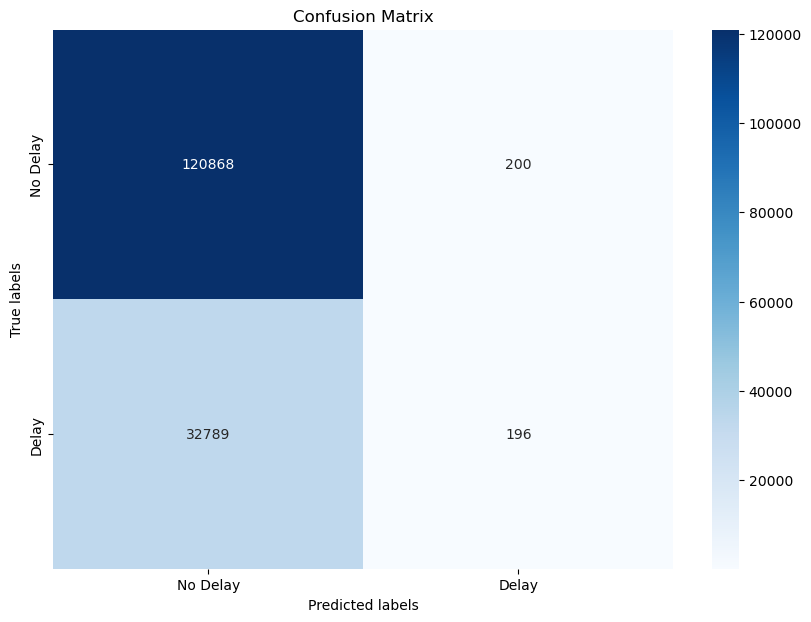

In [69]:
plot_confusion_matrix(real_targets, predicted_targets )

In [70]:
generate_confusion_report(real_targets, predicted_targets)

Confusion Matrix:
[[120868    200]
 [ 32789    196]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    121068
         1.0       0.49      0.01      0.01     32985

    accuracy                           0.79    154053
   macro avg       0.64      0.50      0.45    154053
weighted avg       0.72      0.79      0.69    154053



In [73]:
get_general_results(real_targets, predicted_targets)


Accuracy: 0.7858594120205384
Precision: 0.494949494949495
Recall/Sensitivity: 0.005942094891617402
F1 Score: 0.011743207213684432


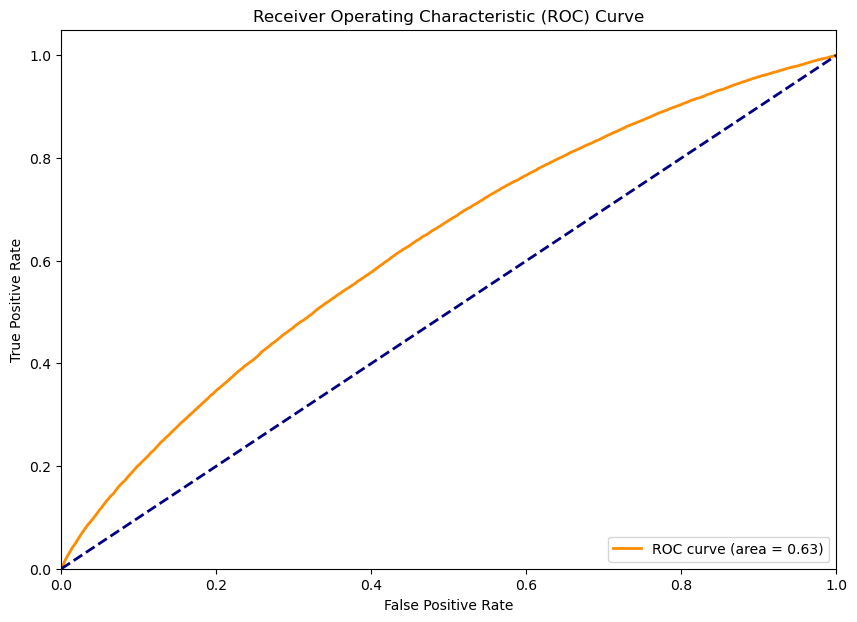

In [80]:
plot_roc(real_targets, predicted_targets_prob)

The first linear model was trained with mini batch size of 200, and only trained for 5 epochs as the training takes quite some time if more epochs were taken. Due to time constraints, epoch was set to only 5.
The first linear model trained on dataset without holiday and weather added resulted in the following results:
* Overall accuracy was about 0.79, which doesnt show much about the model due to imbalanced dataset.
* Even thought the model predicts "No Delay" with precision of 0.79 and recall of 1.00, it's unable to predict "Delay" accurately denoted by its precision of 0.49 and recall of 0.005.
* ROC AUC score of 0.63 reports moderate discriminative power.
Overall, the model isn't useful enough for real business applications due to its inability to accurately predict "Delay" flights.

## Training Linear Model on combined_csv_v2.csv

In [86]:
train, test_and_validate = train_test_split(csv_v2_data, test_size=0.3, random_state=42, stratify=csv_v2_data['target'] )
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])

In [87]:
s3_session = sagemaker.Session()
s3_resource = boto3.Session().resource('s3')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [88]:
bucket=s3_session.default_bucket()
prefix="linear_learner_data_2"

In [90]:
train_file = 'csv_v2_train.csv'
test_file = 'csv_v2_test.csv'
validate_file = 'csv_v2_validate.csv'

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

In [92]:
# creating train and validate channel
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [93]:
# creating the estimator
container = get_image_uri(sagemaker.Session().boto_region_name, 'linear-learner')

linear_v2 = sagemaker.estimator.Estimator(container,
                                       role=sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       sagemaker_session=s3_session)

linear_v2.set_hyperparameters(predictor_type='binary_classifier',
                           mini_batch_size=200, epochs=5)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [94]:
linear_v2.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: linear-learner-2023-11-01-10-24-20-459


2023-11-01 10:24:20 Starting - Starting the training job...
2023-11-01 10:24:47 Starting - Preparing the instances for training.........
2023-11-01 10:26:06 Downloading - Downloading input data...
2023-11-01 10:26:41 Training - Downloading the training image.........
2023-11-01 10:27:52 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/01/2023 10:28:11 INFO 140161772328768] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'los

In [95]:
# hosting on another instance
linear_predictor_v2 = linear_v2.deploy(initial_instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    serializer = sagemaker.serializers.CSVSerializer()
                                   )

INFO:sagemaker:Creating model with name: linear-learner-2023-11-01-10-38-02-877
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-11-01-10-38-02-877
INFO:sagemaker:Creating endpoint with name linear-learner-2023-11-01-10-38-02-877


-------!

In [ ]:
# testing deployed instance

In [96]:
test.shape

(91392, 86)

In [97]:
row = test.iloc[0:1,1:]

In [98]:
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
print(test_row)

641.0,7.0,74.0,20.0,263.0,82.0,74.0,101.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



In [99]:
linear_predictor_v2.predict(test_row)

b'{"predictions": [{"score": 0.16359621286392212, "predicted_label": 0}]}'

In [100]:
test.iloc[0:1,0:]

target  Distance  DepHourofDay  AWND_O  PRCP_O  TAVG_O  AWND_D  \
137222     0.0     641.0           7.0    74.0    20.0   263.0    82.0   

        PRCP_D  TAVG_D  SNOW_O  ...  Origin_SFO  Dest_CLT  Dest_DEN  Dest_DFW  \
137222    74.0   101.0     0.0  ...         0.0       0.0       1.0       0.0   

        Dest_IAH  Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  is_holiday_1  
137222       0.0       0.0       0.0       0.0       0.0           0.0  

[1 rows x 86 columns]

In [101]:
# batch transform

In [102]:
batch_X = test.iloc[:,1:]
batch_X.head()

Distance  DepHourofDay  AWND_O  PRCP_O  TAVG_O  AWND_D  PRCP_D  \
137222     641.0           7.0    74.0    20.0   263.0    82.0    74.0   
470471     689.0           9.0    42.0   142.0   248.0    41.0     0.0   
72728     1744.0           6.0    18.0     0.0   160.0    47.0    48.0   
463994    2139.0          22.0    54.0     0.0   138.0    29.0   102.0   
544007     862.0           7.0    26.0     0.0   279.0    64.0     0.0   

        TAVG_D  SNOW_O  SNOW_D  ...  Origin_SFO  Dest_CLT  Dest_DEN  Dest_DFW  \
137222   101.0     0.0     0.0  ...         0.0       0.0       1.0       0.0   
470471   226.0     0.0     0.0  ...         0.0       0.0       0.0       0.0   
72728     65.0     0.0     0.0  ...         0.0       0.0       0.0       0.0   
463994   242.0     0.0     0.0  ...         1.0       0.0       0.0       0.0   
544007   247.0     0.0     0.0  ...         0.0       0.0       1.0       0.0   

        Dest_IAH  Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  is_holiday_1  
137222       0.0       0.0       0.0       0.0       0.0           0.0  
470471       0.0       0.0       0.0       0.0       0.0           0.0  
72728        0.0       0.0       1.0       0.0       0.0           0.0  
463994       0.0       0.0       0.0       0.0       0.0           0.0  
544007       0.0       0.0       0.0       0.0       0.0           0.0  

[5 rows x 85 columns]

In [103]:
# uploading the test data to s3 in csv
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [104]:
# configuring transformer for batch transform
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

linear_transformer_v2 = linear_v2.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

linear_transformer_v2.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
linear_transformer_v2.wait()

INFO:sagemaker:Creating model with name: linear-learner-2023-11-01-10-42-56-211
INFO:sagemaker:Creating transform job with name: linear-learner-2023-11-01-10-42-56-865


..........................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/01/2023 10:50:00 INFO 140043674982208] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/01/2023 10:50:04 WARNING 140043674982208] Loggers have already been setup.
[11/01/2023 10:50:04 INFO 140043674982208] loaded entry point class algorithm.serve.server_config:config_api
[11/01/2023 10:50:04 INFO 140043674982208] loading entry points
[11/01/2023 10:

In [105]:
# downloading the results from S3 to compare with input

# Initialize boto3 client
s3 = boto3.client('s3')

# Download the file
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
raw_data = io.BytesIO(obj['Body'].read()).read().decode('utf-8').splitlines()

# Parse each line and append to a list
parsed_data = []
for line in raw_data:
    parsed_data.append(json.loads(line))

# Convert the list of dictionaries to a DataFrame
target_predicted = pd.DataFrame(parsed_data)

In [106]:
real_targets = test['target']
predicted_targets = target_predicted["predicted_label"]
predicted_targets_prob = target_predicted["score"]

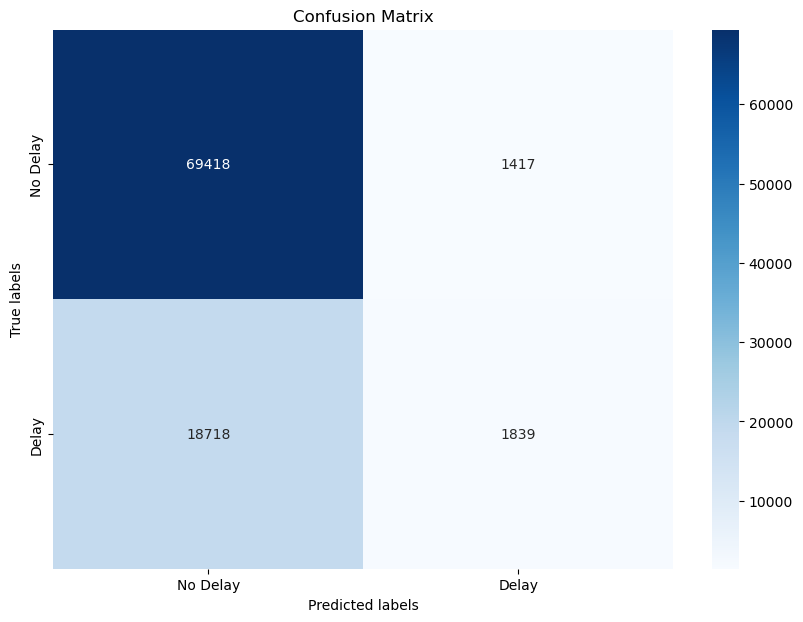

In [107]:
plot_confusion_matrix(real_targets, predicted_targets )

In [108]:
generate_confusion_report(real_targets, predicted_targets)

Confusion Matrix:
[[69418  1417]
 [18718  1839]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.98      0.87     70835
         1.0       0.56      0.09      0.15     20557

    accuracy                           0.78     91392
   macro avg       0.68      0.53      0.51     91392
weighted avg       0.74      0.78      0.71     91392



In [109]:
get_general_results(real_targets, predicted_targets)


Accuracy: 0.7796853116246498
Precision: 0.5648034398034398
Recall/Sensitivity: 0.0894585785863696
F1 Score: 0.15445344979632972


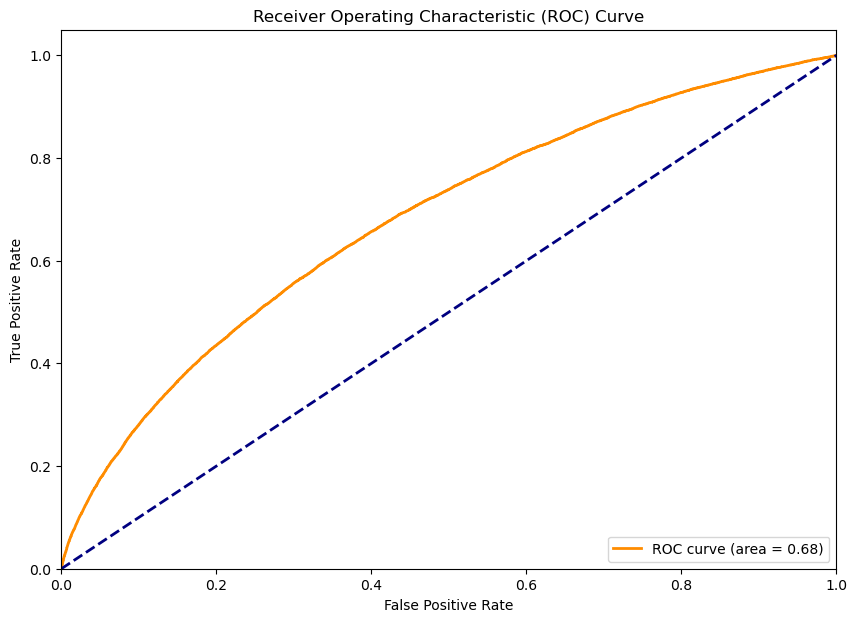

In [110]:
plot_roc(real_targets, predicted_targets_prob)

The second linear model was trained with mini batch size of 200, and only trained for 5 epochs as the training takes quite some time if more epochs were taken. Due to time constraints, epoch was set to only 5.
The second linear model trained on dataset without holiday and weather added resulted in the following results:
* Overall accuracy was about 0.79, which doesnt show much about the model due to imbalanced dataset.
* Even thought the model predicts "No Delay" with precision of 0.79 and recall of 1.00, it's unable to predict "Delay" accurately denoted by its precision of 0.56 and recall of 0.089.
* ROC AUC score of 0.68 reports moderate discriminative power, which is a bit better than first linear model.
The model shows some improvement with the addition of holidays and weather data.
Overall, the model isn't useful enough for real business applications due to its inability to accurately predict "Delay" flights.

# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

## Training ensemble model with combined_csv_v1.csv

In [11]:
# Write the final comments here and turn the cell type into markdown
train, test_and_validate = train_test_split(csv_v1_data, test_size=0.3, random_state=42, stratify=csv_v1_data['target'] )
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])

In [10]:
s3_session = sagemaker.Session()
s3_resource = boto3.Session().resource('s3')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [12]:
bucket=s3_session.default_bucket()
prefix="xbboost_1"

In [13]:
train_file = 'csv_v1_train.csv'
test_file = 'csv_v1_test.csv'
validate_file = 'csv_v1_validate.csv'

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

In [16]:
# creating train and validate channel
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [17]:
# creating the estimator
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

xgboost_v1 = sagemaker.estimator.Estimator(container,
                                       role=sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       hyperparameters=hyperparams,
                                       sagemaker_session=s3_session)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [18]:
xgboost_v1.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-01-12-20-21-151


2023-11-01 12:20:21 Starting - Starting the training job......
2023-11-01 12:20:56 Starting - Preparing the instances for training......
2023-11-01 12:22:18 Downloading - Downloading input data......
2023-11-01 12:22:58 Training - Downloading the training image...
2023-11-01 12:23:34 Training - Training image download completed. Training in progress..[2023-11-01 12:23:51.344 ip-10-0-76-103.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:r

In [19]:
xgb_predictor = xgboost_v1.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-01-12-25-51-887
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-11-01-12-25-51-887
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-11-01-12-25-51-887


--------!

In [20]:
test.shape

(154053, 73)

In [21]:
row = test.iloc[0:1,1:]

In [18]:
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
print(test_row)

370.0,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0



In [24]:
predicted = xgb_predictor.predict(test_row)

In [20]:
def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

In [28]:
predicted = float(predicted.decode('utf-8'))

In [31]:
predicted_label = binary_convert(predicted)

In [32]:
print(f"Predicted Label: {predicted_label}")

Predicted Label: 0


In [41]:
print(f"True Label: {test.iloc[0,0]}")

True Label: 0.0


### Batch Transform to Evaluate The model on testing data

In [21]:
batch_X = test.iloc[:,1:]
batch_X.head()

Distance  DepHourofDay  Quarter_2  Quarter_3  Quarter_4  Month_2  \
512537     370.0          17.0        0.0        1.0        0.0      0.0   
7155       862.0          11.0        0.0        0.0        0.0      0.0   
693999    1199.0          14.0        0.0        0.0        1.0      0.0   
693279     641.0           9.0        0.0        0.0        1.0      0.0   
553962    1846.0          12.0        0.0        1.0        0.0      0.0   

        Month_3  Month_4  Month_5  Month_6  ...  Origin_PHX  Origin_SFO  \
512537      0.0      0.0      0.0      0.0  ...         1.0         0.0   
7155        0.0      0.0      0.0      0.0  ...         0.0         0.0   
693999      0.0      0.0      0.0      0.0  ...         0.0         0.0   
693279      0.0      0.0      0.0      0.0  ...         0.0         0.0   
553962      0.0      0.0      0.0      0.0  ...         0.0         0.0   

        Dest_CLT  Dest_DEN  Dest_DFW  Dest_IAH  Dest_LAX  Dest_ORD  Dest_PHX  \
512537       0.0       0.0       0.0       0.0       1.0       0.0       0.0   
7155         0.0       0.0       0.0       0.0       1.0       0.0       0.0   
693999       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
693279       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
553962       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

        Dest_SFO  
512537       0.0  
7155         0.0  
693999       0.0  
693279       0.0  
553962       1.0  

[5 rows x 72 columns]

In [22]:
# uploading the test data to s3 in csv
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [23]:
# configuring transformer for batch transform
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer_v1 = xgboost_v1.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer_v1.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer_v1.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-01-12-30-29-037
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-01-12-30-29-691


........................................[2023-11-01:12:37:13:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-01:12:37:13:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-01:12:37:13:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-11-01 12:37:13 +0000] [19] [INFO] Star

In [24]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])


In [25]:
target_predicted

target
0       0.247969
1       0.147424
2       0.217677
3       0.280207
4       0.339621
...          ...
154048  0.233467
154049  0.327926
154050  0.215154
154051  0.379271
154052  0.148702

[154053 rows x 1 columns]

In [26]:
target_predicted['label'] = target_predicted['target'].apply(binary_convert)

target  label
0       0.247969      0
1       0.147424      0
2       0.217677      0
3       0.280207      0
4       0.339621      0
...          ...    ...
154048  0.233467      0
154049  0.327926      0
154050  0.215154      0
154051  0.379271      0
154052  0.148702      0

[154053 rows x 2 columns]

In [29]:
real_targets = test['target']
predicted_targets = target_predicted["label"]
predicted_targets_prob = target_predicted["target"]

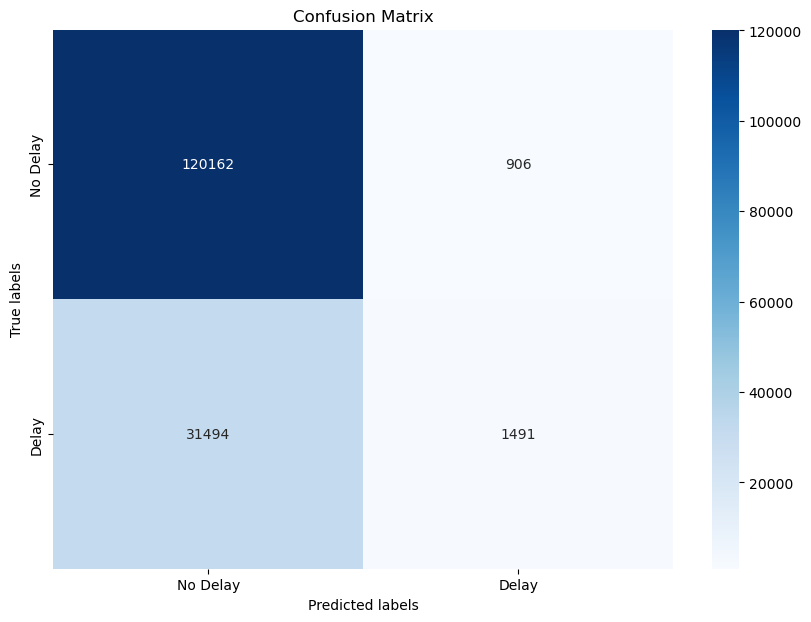

In [30]:
plot_confusion_matrix(real_targets, predicted_targets )

In [33]:
generate_confusion_report(real_targets, predicted_targets)

Confusion Matrix:
[[120162    906]
 [ 31494   1491]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88    121068
         1.0       0.62      0.05      0.08     32985

    accuracy                           0.79    154053
   macro avg       0.71      0.52      0.48    154053
weighted avg       0.76      0.79      0.71    154053



In [34]:
get_general_results(real_targets, predicted_targets)


Accuracy: 0.7896827715136998
Precision: 0.6220275344180225
Recall/Sensitivity: 0.04520236471123238
F1 Score: 0.08428014244531118


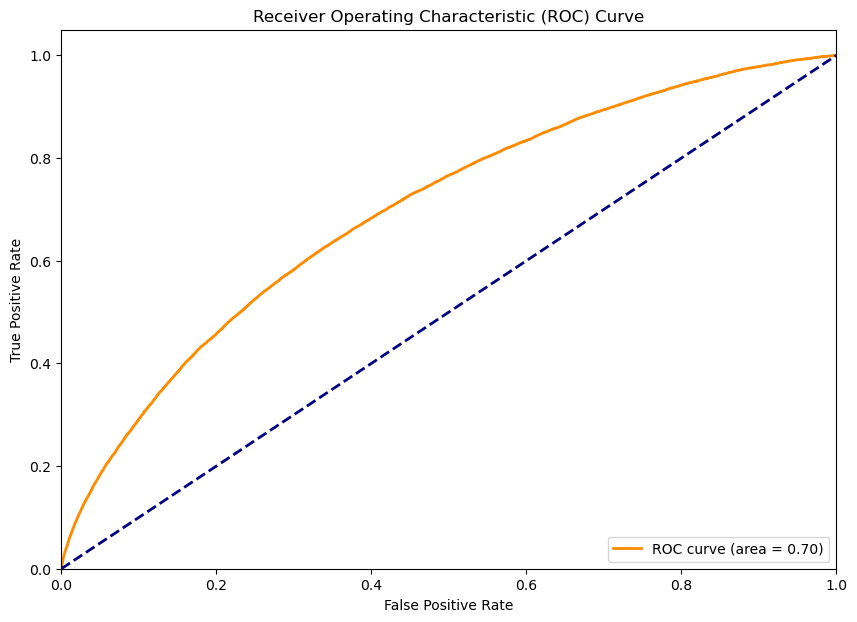

In [35]:
plot_roc(real_targets, predicted_targets_prob)

XGBoost(Ensemble method) performed much better as compared to linear learner model, with precision of 0.62 and recall of 0.05, which is way higher as compared to linear learner.
The AUC was 0.70 which was better as compared to linear learner model. The XGBoost model outperforms the Linear Learner in terms of precision, recall, and the F1 score for predicting delays. Additionally, the ROC AUC of 0.70 for XGBoost indicates a better classification capability than the Linear Learner.

## Training ensemble model with combined_csv_v2.csv

In [36]:
train, test_and_validate = train_test_split(csv_v2_data, test_size=0.3, random_state=42, stratify=csv_v2_data['target'] )
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])

In [38]:
s3_session = sagemaker.Session()
s3_resource = boto3.Session().resource('s3')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [40]:
bucket=s3_session.default_bucket()
prefix="xgboost_2"

In [41]:
train_file = 'csv_v2_train.csv'
test_file = 'csv_v2_test.csv'
validate_file = 'csv_v2_validate.csv'

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

In [42]:
# creating train and validate channel
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [43]:
# creating the estimator
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

xgboost_v2 = sagemaker.estimator.Estimator(container,
                                       role=sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path='s3://{}/{}/output'.format(bucket, prefix),
                                       hyperparameters=hyperparams,
                                       sagemaker_session=s3_session)


INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [44]:
xgboost_v2.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-11-01-12-49-10-071


2023-11-01 12:49:10 Starting - Starting the training job...
2023-11-01 12:49:36 Starting - Preparing the instances for training......
2023-11-01 12:50:40 Downloading - Downloading input data......
2023-11-01 12:51:21 Training - Downloading the training image...
2023-11-01 12:52:01 Training - Training image download completed. Training in progress...[2023-11-01 12:52:17.555 ip-10-2-196-24.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:roo

In [45]:
xgb_predictor_v2 = xgboost_v2.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-01-12-55-38-720
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-11-01-12-55-38-720
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-11-01-12-55-38-720


--------!

In [46]:
test.shape

(91392, 86)

In [47]:
row = test.iloc[0:1,1:]

In [48]:
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
print(test_row)

641.0,7.0,74.0,20.0,263.0,82.0,74.0,101.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



In [50]:
predicted = xgb_predictor_v2.predict(test_row)

In [51]:
predicted = float(predicted.decode('utf-8'))

In [52]:
predicted_label = binary_convert(predicted)

In [53]:
print(f"Predicted Label: {predicted_label}")

Predicted Label: 0


In [54]:
print(f"True Label: {test.iloc[0,0]}")

True Label: 0.0


In [ ]:
# batch transform

In [55]:
batch_X = test.iloc[:,1:]
batch_X.head()

Distance  DepHourofDay  AWND_O  PRCP_O  TAVG_O  AWND_D  PRCP_D  \
137222     641.0           7.0    74.0    20.0   263.0    82.0    74.0   
470471     689.0           9.0    42.0   142.0   248.0    41.0     0.0   
72728     1744.0           6.0    18.0     0.0   160.0    47.0    48.0   
463994    2139.0          22.0    54.0     0.0   138.0    29.0   102.0   
544007     862.0           7.0    26.0     0.0   279.0    64.0     0.0   

        TAVG_D  SNOW_O  SNOW_D  ...  Origin_SFO  Dest_CLT  Dest_DEN  Dest_DFW  \
137222   101.0     0.0     0.0  ...         0.0       0.0       1.0       0.0   
470471   226.0     0.0     0.0  ...         0.0       0.0       0.0       0.0   
72728     65.0     0.0     0.0  ...         0.0       0.0       0.0       0.0   
463994   242.0     0.0     0.0  ...         1.0       0.0       0.0       0.0   
544007   247.0     0.0     0.0  ...         0.0       0.0       1.0       0.0   

        Dest_IAH  Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  is_holiday_1  
137222       0.0       0.0       0.0       0.0       0.0           0.0  
470471       0.0       0.0       0.0       0.0       0.0           0.0  
72728        0.0       0.0       1.0       0.0       0.0           0.0  
463994       0.0       0.0       0.0       0.0       0.0           0.0  
544007       0.0       0.0       0.0       0.0       0.0           0.0  

[5 rows x 85 columns]

In [56]:
# uploading the test data to s3 in csv
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [57]:
# configuring transformer for batch transform
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer_v2 = xgboost_v2.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer_v2.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer_v2.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-11-01-13-04-22-156
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2023-11-01-13-04-22-939


.........................................[2023-11-01:13:11:10:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-01:13:11:10:INFO] No GPUs detected (normal if no gpus installed)
[2023-11-01:13:11:10:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-11-01 13:11:10 +0000] [19] [INFO] Sta

In [58]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])


In [59]:
target_predicted

target
0      0.213284
1      0.122049
2      0.091967
3      0.219419
4      0.108828
...         ...
91387  0.489676
91388  0.175738
91389  0.211139
91390  0.112933
91391  0.089265

[91392 rows x 1 columns]

In [60]:
target_predicted['label'] = target_predicted['target'].apply(binary_convert)

In [61]:
real_targets = test['target']
predicted_targets = target_predicted["label"]
predicted_targets_prob = target_predicted["target"]

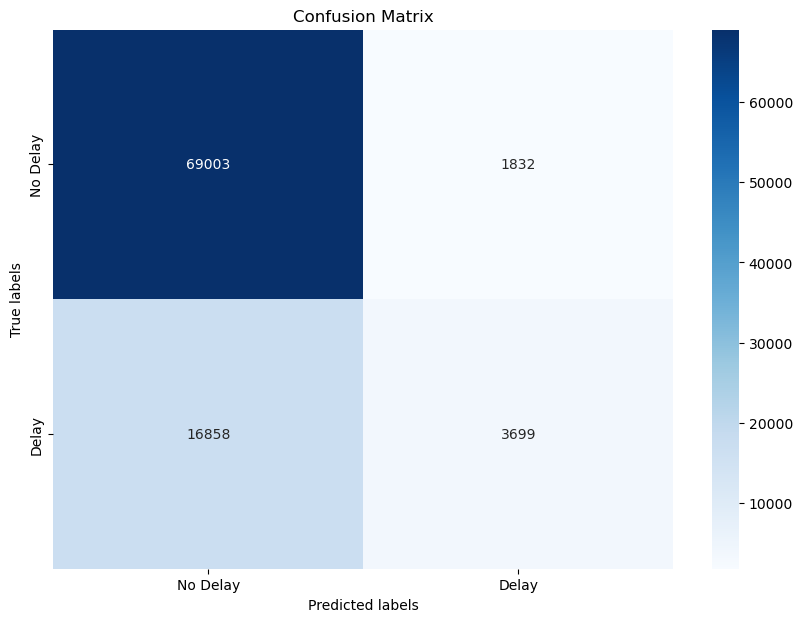

In [62]:
plot_confusion_matrix(real_targets, predicted_targets)

In [63]:
generate_confusion_report(real_targets, predicted_targets)

Confusion Matrix:
[[69003  1832]
 [16858  3699]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.97      0.88     70835
         1.0       0.67      0.18      0.28     20557

    accuracy                           0.80     91392
   macro avg       0.74      0.58      0.58     91392
weighted avg       0.77      0.80      0.75     91392



In [64]:
get_general_results(real_targets, predicted_targets)


Accuracy: 0.7954963235294118
Precision: 0.6687759898752486
Recall/Sensitivity: 0.17993870700977768
F1 Score: 0.28357865685372585


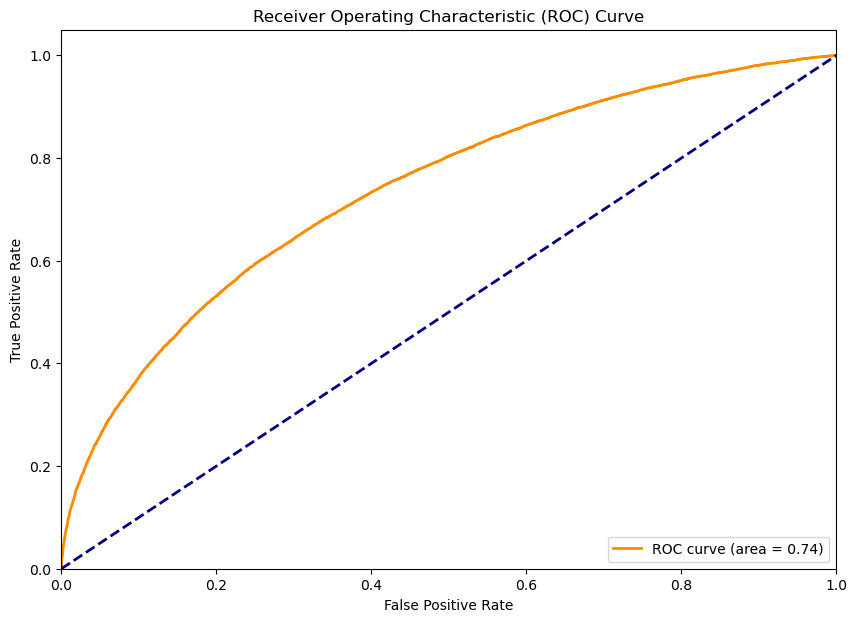

In [65]:
plot_roc(real_targets, predicted_targets_prob)

For the modified dataset with holiday and weather, the XGBoost method was even better. XGBoost model significantly improved the recall for predicting delays from 4.52% to 18%. This is much higher as compared to linear learner model. AUC of 0.74 also revealed the improved discriminative power of the model. Thus far, this model has performed the best among all the models trained on premises, and on cloud. Even so, this model still isnt enough for the business needs in real life scenario.

## Comparison of Simple Model(Linear Learner) and Ensemble Model(XGBoost)

| Metric / Model                   | Linear Learner | Linear Learner (With Holiday & Weather) | XGBoost                           | XGBoost (With Holiday & Weather) |
|---------------------------------|----------------|----------------------------------------|-------------------------------------|----------------------------------|
| Accuracy                        | 0.7858         | 0.7797                                 | 0.7896                              | 0.7954                           |
| Precision (Class 1)             | 0.4949         | 0.5648                                 | 0.6220                              | 0.6687                           |
| Recall (Class 1)                | 0.0059         | 0.0895                                 | 0.0452                              | 0.1799                           |
| F1 Score (Class 1)              | 0.0117         | 0.1545                                 | 0.0842                              | 0.2835                           |
| ROC AUC                         | 0.63           | 0.68                                   | 0.70                                | 0.74                             |



| Observation                 | Linear Learner | XGBoost                                |
|-----------------------------|----------------|----------------------------------------|
| Model Type                  | Simple Model  | Ensemble Model                         |
| Performance                 | Lower         | Higher (better precision, recall, F1)  |
| Recall                      | Lower         | Higher (identifies more actual delays) |
| ROC AUC                     | Lower         | Higher (better discriminative power)   |


XGBoost, an ensemble model, consistently outperforms the Linear Learner, especially when leveraging additional holiday and weather data, achieving higher recall and superior discriminative power.

## Comparison of OnPremise and OnCloud
Based on my experience, the results of implementing ML pipeline on premises vs on cloud are:
* Training on premise was much faster in my case due to benefiting from dedicated resources. In comparison, training was much slower on cloud due to shared resources and network latency.
* While training on premise, no problem was faced. However, while training on cloud, there was disconnection with kernel on numerous ocassion causing the training in the notebook to halt.
* Entire csv file could be used on premise, but on cloud entirety of csv couldnt be uploaded due to network error, which resulted in modifying code to drop null values introduced by incomplete upload of data
* Deployment was quicker in cloud as it developed a ready-to-use path for generating result where i could send http request to get prediction. If such deployment was needed on premise, server needs to be setup using frameworks like FastAPI, Django, etc.
* Best performance was obtained on XGBoost method which was trained on cloud, however similar results could be obtained if XGBoost was trained on premise.